# Using OpenSTL in your own project

In this notebook, we will provide a comprehensive guide on how to use OpenSTL for your own project. 

Firstly, we will process video data into `.npy` format for easier storage and access. Next, we will demonstrate how to utilize custom data within OpenSTL. Subsequently, we will use OpenSTL to train and evaluate models. Finally, we will visualize predicted frames and generate `.gif` images or videos. 

- [1. Preprocess your data](#1-process-your-data)
    - [1.1 Save the dataset](#11-save-the-dataset)
    - [1.2 Load the dataset and visualize an example](#12-load-the-dataset-and-visualize-an-example)

- [2. Utilize cumtom data](#2-utilize-cumtom-data)
    - [2.1 Define the dataset](#21-define-the-dataset)
    - [2.2 Get the dataloaders](#22-get-the-dataloaders)

- [3. Train and evaluate](#3-train-and-evaluate)
    - [3.1 Define the custom configs](#31-define-the-custom-configs)
    - [3.2 Setup the experiment](#32-setup-the-experiment)
    - [3.3 Start training and evaluation](#33)

- [4. Visualization](#4-visualization)
    - [4.1 Visualize in a line](#41-visualize-in-a-line)
    - [4.2 Generate a GIF](#42-generate-a-gif)

Here we go!

## 1. Process your data

Assume you possess a collection of videos and have already sorted them into the `train/`, `val/`, and `test/` directories. The subsequent step involves transforming these videos into a `.pkl` file for further manipulations.

The existing file hierarchy is as follows:

- custom_usage.ipynb
- train
  - train_example1.avi
  - train_example2.avi
- val
  - val_example1.avi
  - val_example2.avi
- test
  - test_example.avi

It's crucial to note that the above example represents a simplified scenario where we've used `.avi` videos for illustrative purposes. However, in a real-world application, you are free to employ videos in various other formats.

We utilize several videos from the KTH dataset as examples. Although the original KTH dataset consists of single-channel grayscale videos, we save them as three-channel RGB videos to accommodate a broader range of use cases.

### 1.1 Save the dataset

Here, we default to uniformly sampling several frames from the given video data. The number of observed frames and future frames are two hyperparameters (`pre_seq_length`, `aft_seq_length`) that are set in advance. You can also choose to sample the video in other ways and save the data.

#### hyperparameters

`pre_seq_length`: the number of given frames

`aft_seq_length`: the number of frames to predict

### 1.2 Load the dataset and visualize an example

In [1]:
import pickle
import cv2
import numpy as np
import os
import time
import torch
from torch.utils.data import Dataset
import re
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
import torch.nn.functional as F

from openstl.utils import show_video_line
from openstl.api import BaseExperiment
from openstl.utils import create_parser, default_parser

In [2]:
pre_seq_length = 12
aft_seq_length = 12

# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)
# the shape is B x T x C x H x W
# B: the number of samples
# T: the number of frames in each sample
# C, H, W: the channels, height and width  of each frame

(1735, 12, 1, 144, 144)


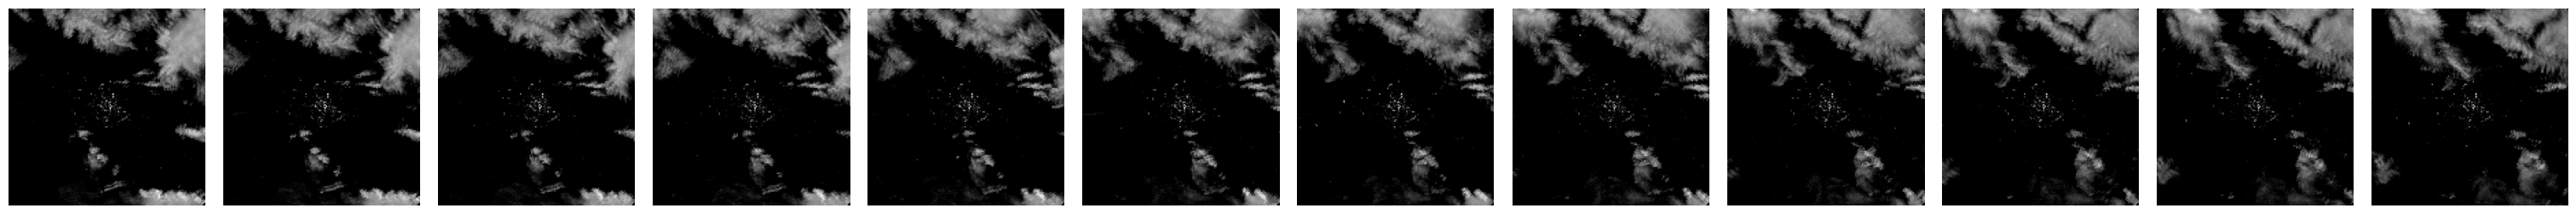

In [3]:
# show the given frames from an example
example_idx = 0
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

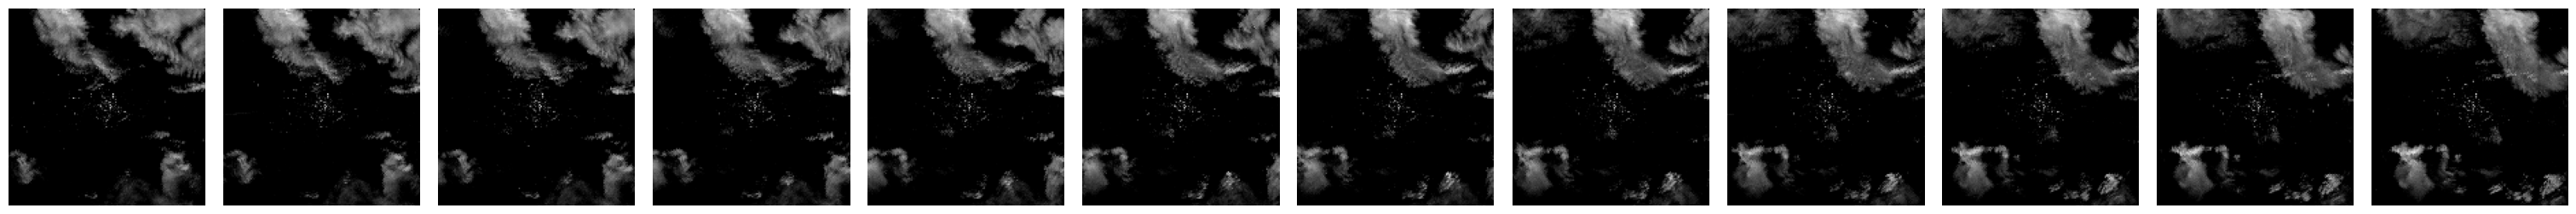

In [4]:
# show the future frames from an example
example_idx = 0
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=False)

## 2. Utilize cumtom data

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [5]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'val_batch_size': 1,
    'epoch': 50,
    'metrics': ['mae', 'mse'],
    "num_workers": 	8,
    "warmup_epoch": 	5,
    "warmup_lr": 	1e-06,
    
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [12, 1, 144, 144],
}

custom_model_config = {
    'method': 'SimVP', #SimVP #PredRNNv2 # MMVP #SwinLSTM #WaST
    # Users can either using a config file or directly set these hyperparameters 
    # 'config_file': 'configs/custom/example_model.py', there are example for all models parameters in /configs

    #loss function for simVP models, tau, phydnet
    'loss': 'mse', # 'mse', 'mae', 'weight', 'msce', 'weightmsce', vggperceptual
}

ConvLSTM_training_config = {
    # ConvLSTM
    # reverse scheduled sampling
    "reverse_scheduled_sampling" : 0,
    "r_sampling_step_1" : 25000,
    "r_sampling_step_2" : 50000,
    "r_exp_alpha" : 5000,
    # scheduled sampling
    "scheduled_sampling" : 1,
    "sampling_stop_iter" : 50000,
    "sampling_start_value" : 1.0,
    "sampling_changing_rate" : 0.00002,
    # model
    "num_hidden" : '32,32,32,32',
    "filter_size" : 5,
    "stride" : 1,
    "patch_size" : 2,
    "layer_norm" : 0,
    # train params
    'batch_size': 4,
    "drop": 0.,
    'drop_path': 0.1,
    "weight_decay": 0.,
    'lr': 0.001, 
    'sched': 'onecycle',
}

PredRNNv2_training_config = {
    #PredRNNv2
    'num_hidden': '128,128,128,128',
    'filter_size': 5,
    'stride': 1,
    'patch_size': 2,
    'layer_norm': 0,
    'decouple_beta': 0.1,
    # reverse scheduled sampling
    'reverse_scheduled_sampling': 1,
    'r_sampling_step_1': 25000,
    'r_sampling_step_2': 50000,
    'r_exp_alpha': 5000,
    # scheduled sampling
    'scheduled_sampling': 1,
    'sampling_stop_iter': 50000,
    'sampling_start_value': 1.0,
    'sampling_changing_rate': 0.00002,
    # train params
    'batch_size': 2,
    "drop": 0.,
    'drop_path': 0.1,
    "weight_decay": 0.,
    'lr': 0.001, 
    'sched': 'onecycle',
}

SimVP_training_config = {
    # For MetaVP models, the most important hyperparameters are: 
    # N_S, N_T, hid_S, hid_T, model_type
    
    # Here, we directly set these parameters
    'model_type': 'swin', #Swin #MogaNET 
    'N_S': 2, #4
    'N_T': 8, #8
    'hid_S': 32, #64
    'hid_T': 256 , #512
    'spatio_kernel_enc': 3,
    'spatio_kernel_dec': 3,
    # train params
    'batch_size': 4,
    "drop": 0.1,
    'drop_path': 0.1,
    "weight_decay": 0.,
    'lr': 0.001, 
    'sched': 'onecycle',
}

SwinLSTM_D_training_config = {
    # SwinLSTM_D
    "depths_downsample" : '2,6',
    "depths_upsample" : '6,2',
    "num_heads": '8,16',
    "patch_size": 2,
    "window_size": 6,
    "embed_dim": 160,
    # train params
    'batch_size': 1,
    "drop": 0.,
    'drop_path': 0.1,
    "weight_decay": 0.,
    'lr': 0.001, 
    'sched': 'onecycle',
}

WaST_training_config = {
   # WaST
    'encoder_dim': 32,
    'block_list': [2, 8, 2],
    'mlp_ratio': 4.0,
    'loss_weight': 0.001,
    # drop scheduler
    "cutmode": "late",  # early or late
    "cutoff": 20,
    # train params
    'batch_size': 1,
    "drop": 0.,
    'drop_path': 0.25,
    "weight_decay": 0.,
    'lr': 0.001, 
    'sched': 'cosine',
}

model_config = globals()[custom_model_config['method'] + '_training_config']

custom_training_config.update(model_config)

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset. 

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False, data_name = "custom"):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None
        self.data_name = data_name

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

In [7]:
batch_size = custom_training_config["batch_size"]

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

In [8]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = dataset['X_train'], dataset[
    'X_val'], dataset['X_test'], dataset['Y_train'], dataset['Y_val'], dataset['Y_test']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)
test_set = CustomDataset(X=X_test, Y=Y_test)

In [9]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

## 3. Train and evaluate

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`. 

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [10]:
args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)
# fulfill with default values
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

exp = BaseExperiment(args, dataloaders=(dataloader_train, dataloader_val, dataloader_test),strategy="dp")

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation. 

Here we go!

In [11]:
torch.set_float32_matmul_precision('high')  #Choose matrix mutiplication precision between "highest" "high" "medium"

print('>'*35 + ' training ' + '<'*35)
start_time = time.time()
exp.train()
train_time = time.time() - start_time
print('>'*35 + ' testing  ' + '<'*35)
exp.test()

Missing logger folder: tb_logs\simvp_mse_50epochs_6
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<



  | Name      | Type        | Params
------------------------------------------
0 | model     | SimVP_Model | 12.4 M
1 | criterion | MSELoss     | 0     
------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.671    Total estimated model params size (MB)


Environment info:
------------------------------------------------------------
sys.platform: win32
Python: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:33) [MSC v.1929 64 bit (AMD64)]
CUDA available: True
CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.3
NVCC: Not Available
GPU 0: NVIDIA GeForce RTX 4080
GCC: <built-in method strip of str object at 0x000001F2A1B52730>
PyTorch: 2.1.0
PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX512
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-ge

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 434: 'val_loss' reached 0.00812 (best 0.00812), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=00-val_loss=0.00812.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 868: 'val_loss' reached 0.00692 (best 0.00692), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=01-val_loss=0.00692.ckpt' as top 1


Epoch 1: Lr: 0.0000400 | Train Loss: 0.0109893 | Vali Loss: 0.0069242


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 1302: 'val_loss' reached 0.00637 (best 0.00637), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=02-val_loss=0.00637.ckpt' as top 1


Epoch 2: Lr: 0.0000400 | Train Loss: 0.0065070 | Vali Loss: 0.0063650


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 1736: 'val_loss' reached 0.00603 (best 0.00603), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=03-val_loss=0.00603.ckpt' as top 1


Epoch 3: Lr: 0.0000400 | Train Loss: 0.0057188 | Vali Loss: 0.0060312


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 2170: 'val_loss' was not in top 1


Epoch 4: Lr: 0.0000400 | Train Loss: 0.0053037 | Vali Loss: 0.0063866


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 2604: 'val_loss' reached 0.00559 (best 0.00559), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=05-val_loss=0.00559.ckpt' as top 1


Epoch 5: Lr: 0.0000400 | Train Loss: 0.0050446 | Vali Loss: 0.0055875


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 3038: 'val_loss' reached 0.00536 (best 0.00536), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=06-val_loss=0.00536.ckpt' as top 1


Epoch 6: Lr: 0.0000400 | Train Loss: 0.0049338 | Vali Loss: 0.0053638


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 3472: 'val_loss' reached 0.00528 (best 0.00528), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=07-val_loss=0.00528.ckpt' as top 1


Epoch 7: Lr: 0.0000400 | Train Loss: 0.0047682 | Vali Loss: 0.0052822


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 3906: 'val_loss' reached 0.00510 (best 0.00510), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=08-val_loss=0.00510.ckpt' as top 1


Epoch 8: Lr: 0.0000400 | Train Loss: 0.0046866 | Vali Loss: 0.0051025


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 4340: 'val_loss' was not in top 1


Epoch 9: Lr: 0.0000400 | Train Loss: 0.0045271 | Vali Loss: 0.0051220


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 4774: 'val_loss' reached 0.00489 (best 0.00489), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=10-val_loss=0.00489.ckpt' as top 1


Epoch 10: Lr: 0.0000400 | Train Loss: 0.0044550 | Vali Loss: 0.0048919


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 5208: 'val_loss' reached 0.00483 (best 0.00483), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=11-val_loss=0.00483.ckpt' as top 1


Epoch 11: Lr: 0.0000400 | Train Loss: 0.0043336 | Vali Loss: 0.0048317


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 5642: 'val_loss' reached 0.00481 (best 0.00481), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=12-val_loss=0.00481.ckpt' as top 1


Epoch 12: Lr: 0.0000400 | Train Loss: 0.0043683 | Vali Loss: 0.0048112


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 6076: 'val_loss' was not in top 1


Epoch 13: Lr: 0.0000400 | Train Loss: 0.0042372 | Vali Loss: 0.0048225


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 6510: 'val_loss' reached 0.00471 (best 0.00471), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=14-val_loss=0.00471.ckpt' as top 1


Epoch 14: Lr: 0.0000400 | Train Loss: 0.0042187 | Vali Loss: 0.0047056


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 6944: 'val_loss' was not in top 1


Epoch 15: Lr: 0.0000400 | Train Loss: 0.0041570 | Vali Loss: 0.0047300


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 7378: 'val_loss' reached 0.00470 (best 0.00470), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=16-val_loss=0.00470.ckpt' as top 1


Epoch 16: Lr: 0.0000400 | Train Loss: 0.0040751 | Vali Loss: 0.0046986


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 7812: 'val_loss' reached 0.00459 (best 0.00459), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=17-val_loss=0.00459.ckpt' as top 1


Epoch 17: Lr: 0.0000400 | Train Loss: 0.0040629 | Vali Loss: 0.0045884


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 8246: 'val_loss' reached 0.00455 (best 0.00455), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=18-val_loss=0.00455.ckpt' as top 1


Epoch 18: Lr: 0.0000400 | Train Loss: 0.0040338 | Vali Loss: 0.0045475


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 8680: 'val_loss' was not in top 1


Epoch 19: Lr: 0.0000400 | Train Loss: 0.0039702 | Vali Loss: 0.0045534


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 9114: 'val_loss' reached 0.00447 (best 0.00447), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=20-val_loss=0.00447.ckpt' as top 1


Epoch 20: Lr: 0.0000400 | Train Loss: 0.0039603 | Vali Loss: 0.0044692


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 9548: 'val_loss' was not in top 1


Epoch 21: Lr: 0.0000400 | Train Loss: 0.0039158 | Vali Loss: 0.0045609


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 9982: 'val_loss' was not in top 1


Epoch 22: Lr: 0.0000400 | Train Loss: 0.0038698 | Vali Loss: 0.0044783


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 10416: 'val_loss' reached 0.00445 (best 0.00445), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=23-val_loss=0.00445.ckpt' as top 1


Epoch 23: Lr: 0.0000400 | Train Loss: 0.0038927 | Vali Loss: 0.0044472


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 10850: 'val_loss' was not in top 1


Epoch 24: Lr: 0.0000400 | Train Loss: 0.0038250 | Vali Loss: 0.0045240


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 11284: 'val_loss' reached 0.00437 (best 0.00437), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=25-val_loss=0.00437.ckpt' as top 1


Epoch 25: Lr: 0.0000400 | Train Loss: 0.0037881 | Vali Loss: 0.0043654


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 11718: 'val_loss' was not in top 1


Epoch 26: Lr: 0.0000400 | Train Loss: 0.0037776 | Vali Loss: 0.0044746


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 12152: 'val_loss' was not in top 1


Epoch 27: Lr: 0.0000400 | Train Loss: 0.0037790 | Vali Loss: 0.0045904


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 12586: 'val_loss' was not in top 1


Epoch 28: Lr: 0.0000400 | Train Loss: 0.0037130 | Vali Loss: 0.0044603


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 13020: 'val_loss' reached 0.00434 (best 0.00434), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=29-val_loss=0.00434.ckpt' as top 1


Epoch 29: Lr: 0.0000400 | Train Loss: 0.0037258 | Vali Loss: 0.0043408


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 13454: 'val_loss' was not in top 1


Epoch 30: Lr: 0.0000401 | Train Loss: 0.0036902 | Vali Loss: 0.0044912


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 13888: 'val_loss' was not in top 1


Epoch 31: Lr: 0.0000401 | Train Loss: 0.0036356 | Vali Loss: 0.0043777


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 14322: 'val_loss' was not in top 1


Epoch 32: Lr: 0.0000401 | Train Loss: 0.0036170 | Vali Loss: 0.0045303


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 14756: 'val_loss' reached 0.00433 (best 0.00433), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=33-val_loss=0.00433.ckpt' as top 1


Epoch 33: Lr: 0.0000401 | Train Loss: 0.0035963 | Vali Loss: 0.0043288


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 15190: 'val_loss' reached 0.00426 (best 0.00426), saving model to 'work_dirs\\custom_exp\\checkpoints\\simvp_mse_50epochs_6_best-epoch=34-val_loss=0.00426.ckpt' as top 1


Epoch 34: Lr: 0.0000401 | Train Loss: 0.0035958 | Vali Loss: 0.0042615


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 15624: 'val_loss' was not in top 1


Epoch 35: Lr: 0.0000401 | Train Loss: 0.0035313 | Vali Loss: 0.0044674


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 16058: 'val_loss' was not in top 1


Epoch 36: Lr: 0.0000401 | Train Loss: 0.0035612 | Vali Loss: 0.0043032


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 16492: 'val_loss' was not in top 1


Epoch 37: Lr: 0.0000401 | Train Loss: 0.0035256 | Vali Loss: 0.0044459


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 16926: 'val_loss' was not in top 1


Epoch 38: Lr: 0.0000401 | Train Loss: 0.0034648 | Vali Loss: 0.0043516


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 17360: 'val_loss' was not in top 1


Epoch 39: Lr: 0.0000401 | Train Loss: 0.0034790 | Vali Loss: 0.0043036


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 17794: 'val_loss' was not in top 1


Epoch 40: Lr: 0.0000401 | Train Loss: 0.0034713 | Vali Loss: 0.0043044


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 18228: 'val_loss' was not in top 1


Epoch 41: Lr: 0.0000401 | Train Loss: 0.0034379 | Vali Loss: 0.0043265


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 18662: 'val_loss' was not in top 1


Epoch 42: Lr: 0.0000401 | Train Loss: 0.0033845 | Vali Loss: 0.0043124


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 19096: 'val_loss' was not in top 1


Epoch 43: Lr: 0.0000401 | Train Loss: 0.0033752 | Vali Loss: 0.0042960


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 19530: 'val_loss' was not in top 1


Epoch 44: Lr: 0.0000401 | Train Loss: 0.0033608 | Vali Loss: 0.0044194


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 19964: 'val_loss' was not in top 1


Epoch 45: Lr: 0.0000401 | Train Loss: 0.0033408 | Vali Loss: 0.0043331


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 20398: 'val_loss' was not in top 1


Epoch 46: Lr: 0.0000401 | Train Loss: 0.0033125 | Vali Loss: 0.0042663


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 20832: 'val_loss' was not in top 1


Epoch 47: Lr: 0.0000401 | Train Loss: 0.0032833 | Vali Loss: 0.0043181


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 21266: 'val_loss' was not in top 1


Epoch 48: Lr: 0.0000401 | Train Loss: 0.0032723 | Vali Loss: 0.0042833


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 21700: 'val_loss' was not in top 1


Epoch 49: Lr: 0.0000401 | Train Loss: 0.0032910 | Vali Loss: 0.0043279


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Testing: 0it [00:00, ?it/s]

mse:93.01644897460938, mae:695.8397216796875


In [12]:
# # To run a pre-trained model:
# pretrained_params = torch.load("work_dirs\custom_exp\checkpoints\swinlstm_d_weight_50epochs_1_best-epoch=47-val_loss=0.00604.ckpt") #ckpt and pth both should work
# exp.method.load_state_dict(pretrained_params["state_dict"])

# exp.test()

### 4 Saving visualisation, metrics and model parameters

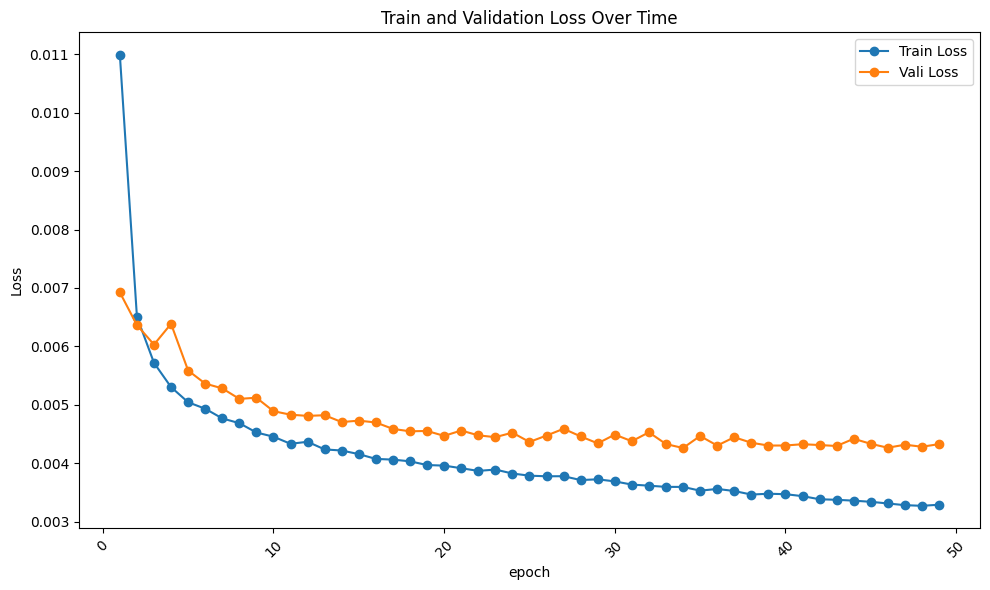

In [13]:
#Check if the folder exists
if not os.path.exists("work_dirs/custom_exp/models"):
    # Create the folder if it doesn't exist
    os.makedirs("work_dirs/custom_exp/models")


def parse_log_line(line):
    """
    Look at the losses from the log file during training and validation.
    """
    match = re.search(r'Train Loss: (\d+\.\d+) \| Vali Loss: (\d+\.\d+)', line)
    if match:
        train_loss = float(match.group(1))
        val_loss = float(match.group(2))
        return train_loss, val_loss
    else:
        return None

def plot_losses(log_file):
    """
    Plot the training and validation losses over the epochs.
    """
    train_losses = []
    val_losses = []
    timestamps = []

    with open(log_file, 'r') as file:
        epoch = 0
        epochs = []
        for line in file:

            losses = parse_log_line(line)
            if losses:
                train_loss, val_loss = losses
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                epoch+=1
                epochs.append(epoch)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Vali Loss', marker='o')
    plt.title('Train and Validation Loss Over Time')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"work_dirs/custom_exp/models/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_losses.jpg")

# Example usage
log_file_path = f'./work_dirs/custom_exp/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.log'
plot_losses(log_file_path)

In [14]:
# Function to extract params and FLOPs from the log file
def extract_model_info(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Use regular expressions to extract the nb of params and FLOPs
    match = re.search(r'\| [^\s]+\s*\| ([0-9]*\.[0-9]+[TGM])+\s*\| ([0-9]*\.[0-9]+[TGM])+\s*\|', content, re.DOTALL)

    if match:
        params_size = match.group(1)
        flops = match.group(2)

        return params_size, flops
    else:
        return "Model information not found in the file."

nb_params, flops = extract_model_info(log_file_path)

In [15]:
# load the inputs, predictions and ground truth from the saved numpy arrays
inputs = np.load(f'./work_dirs/custom_exp/saved/inputs_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')
preds = np.load(f'./work_dirs/custom_exp/saved/preds_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')
trues = np.load(f'./work_dirs/custom_exp/saved/trues_{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}.npy')

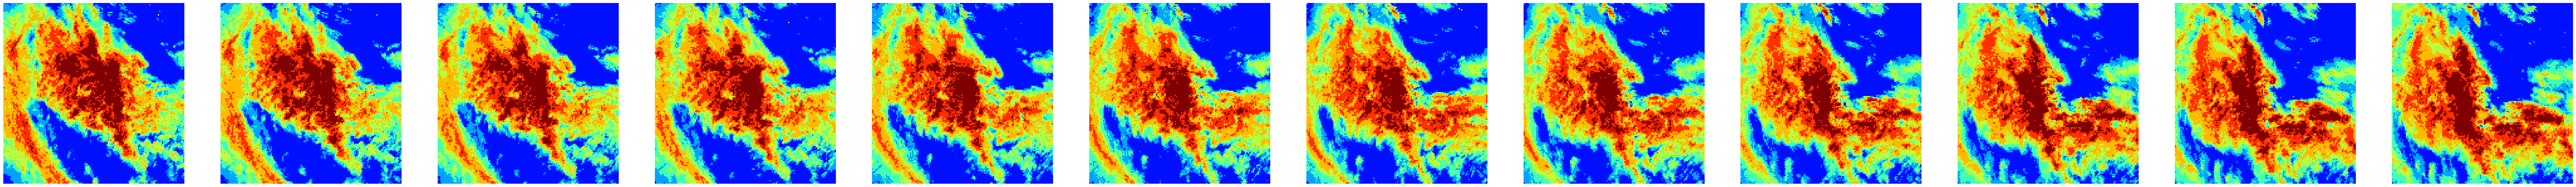

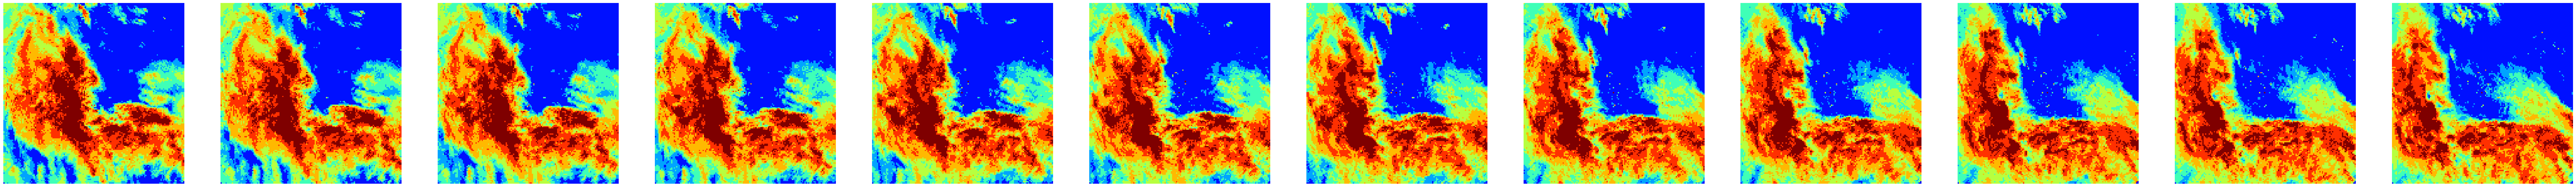

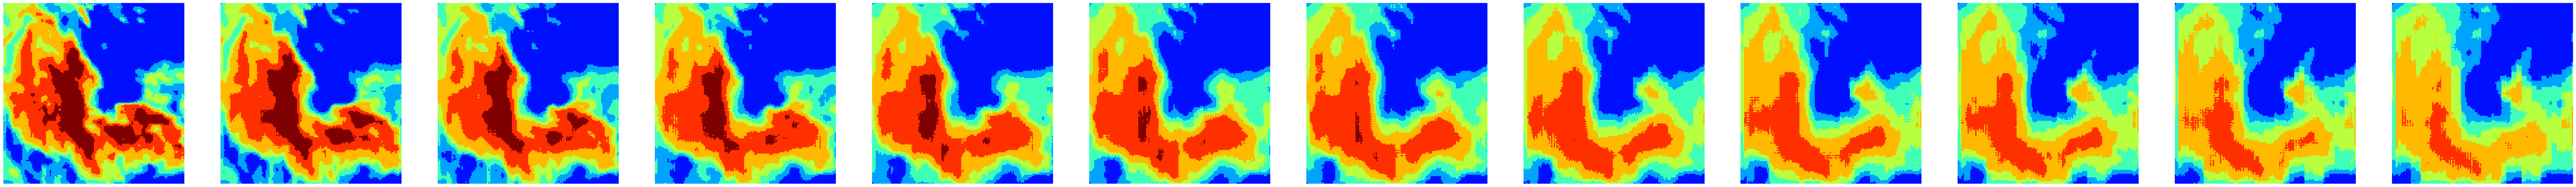

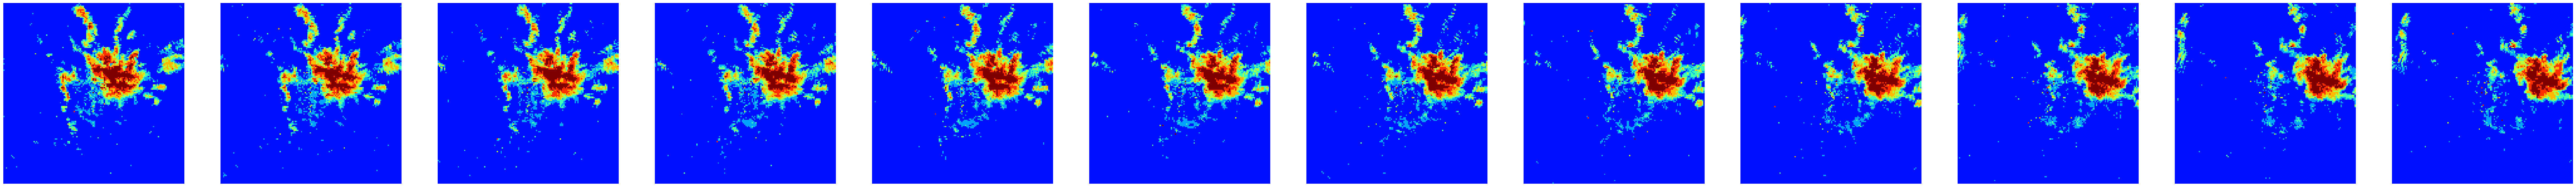

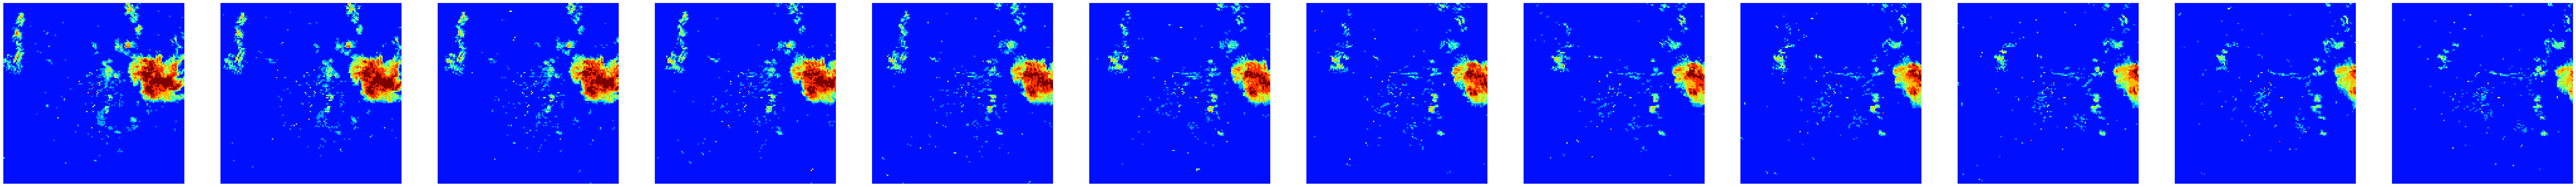

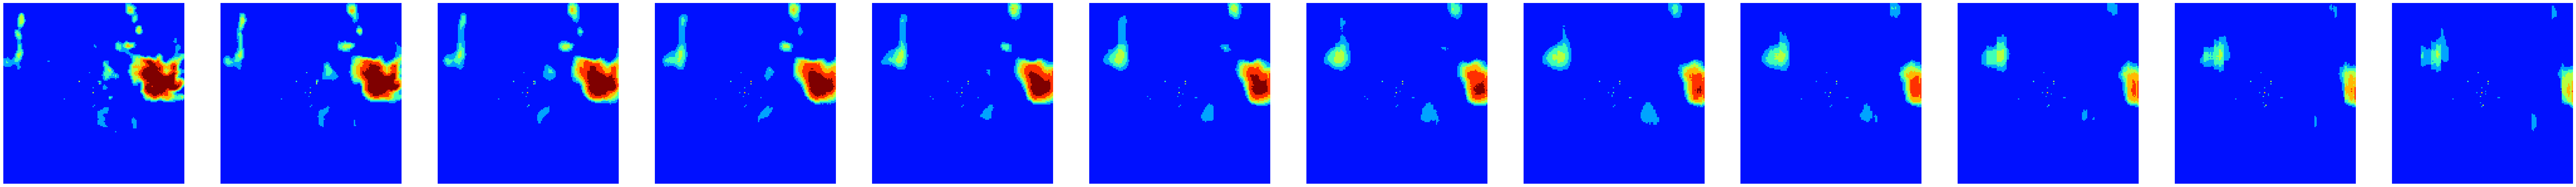

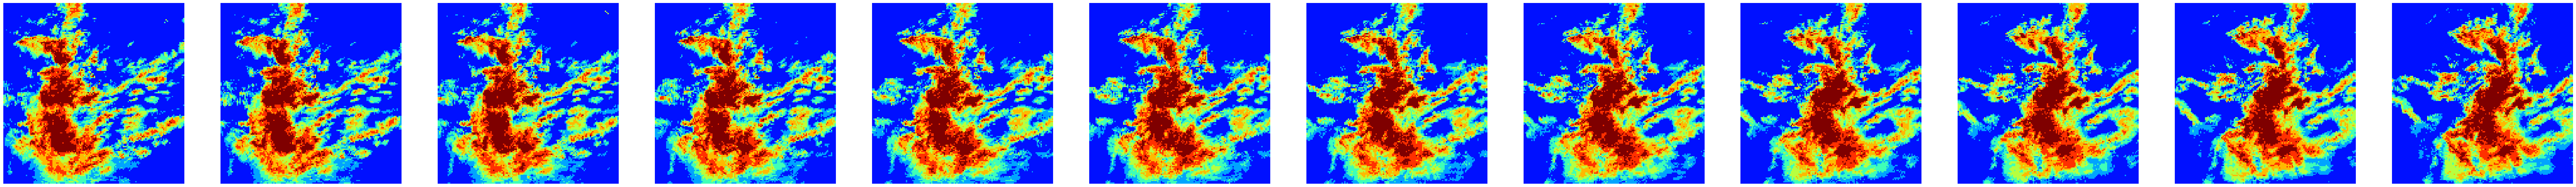

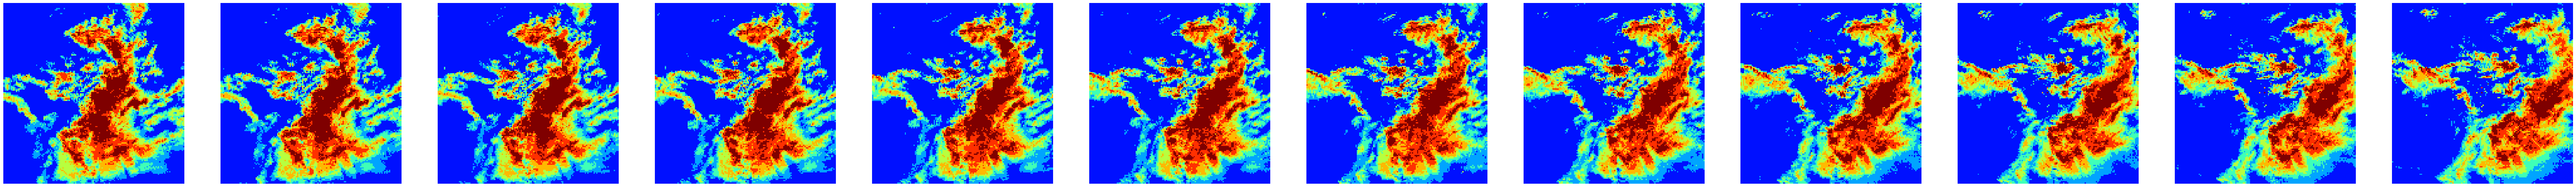

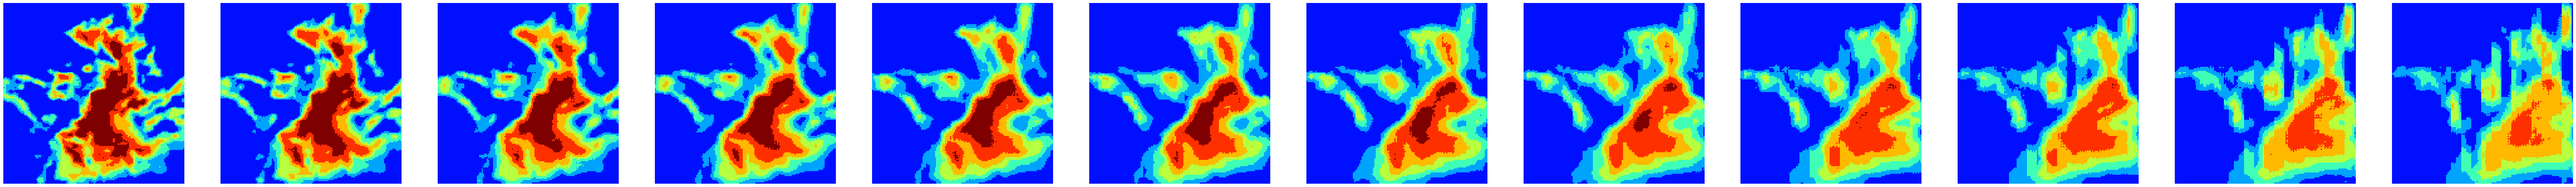

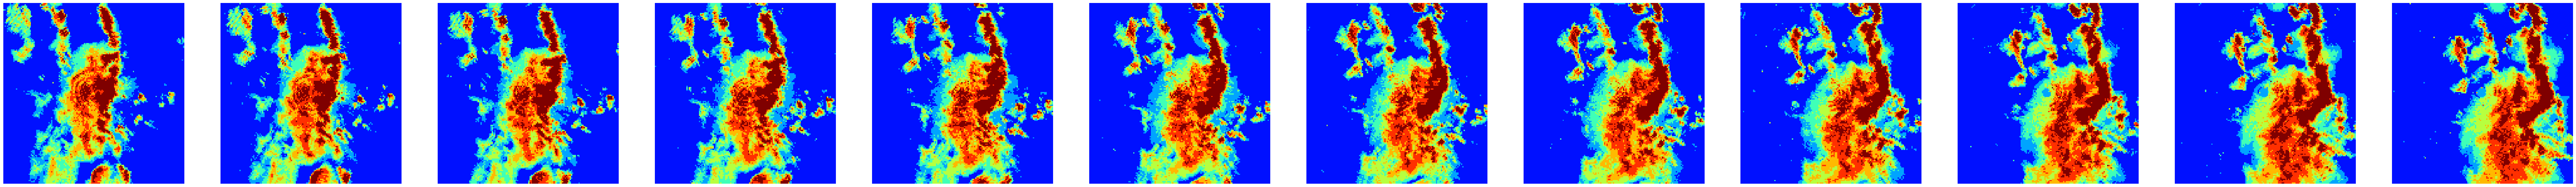

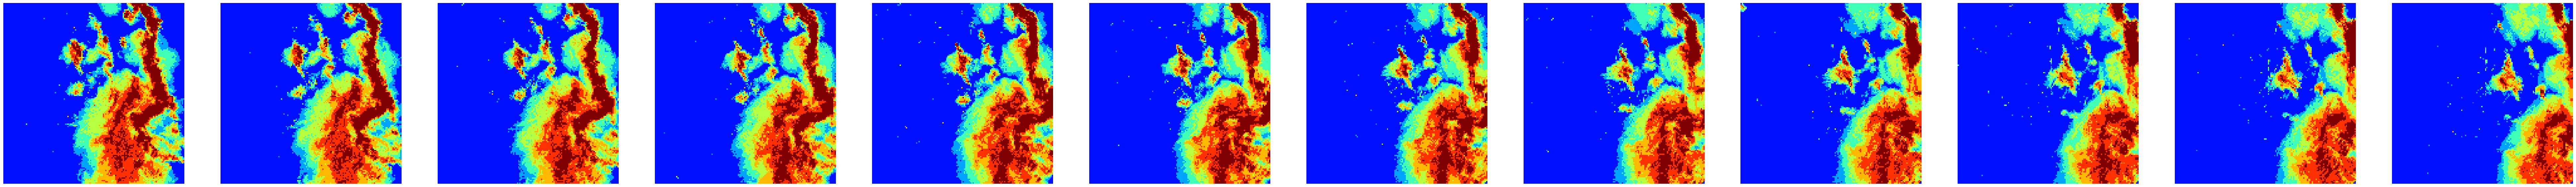

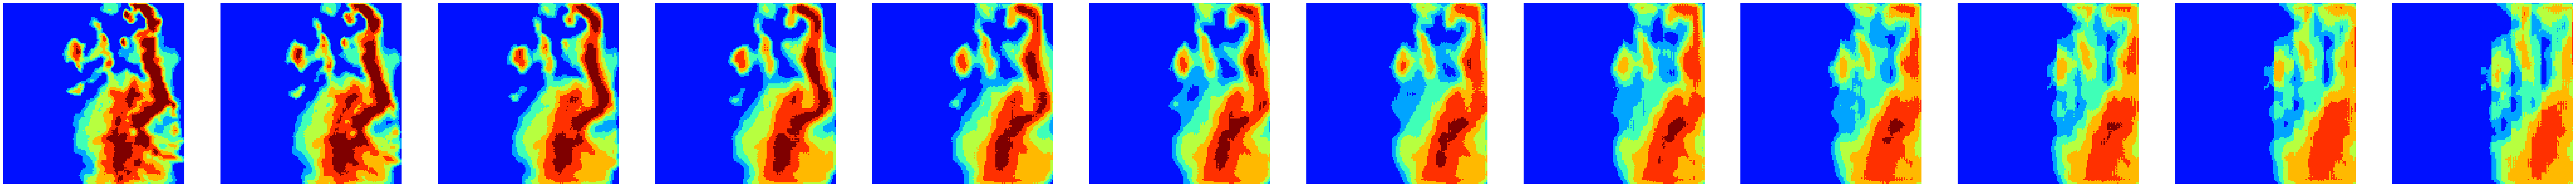

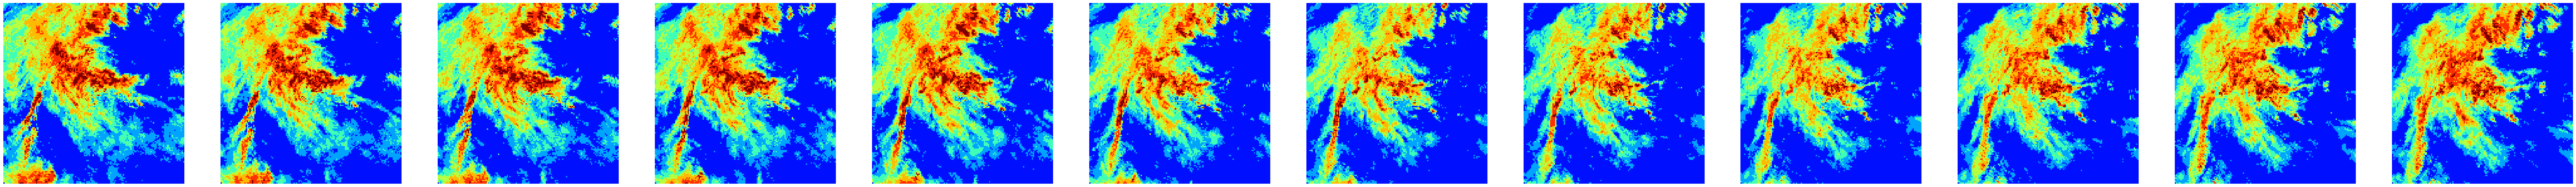

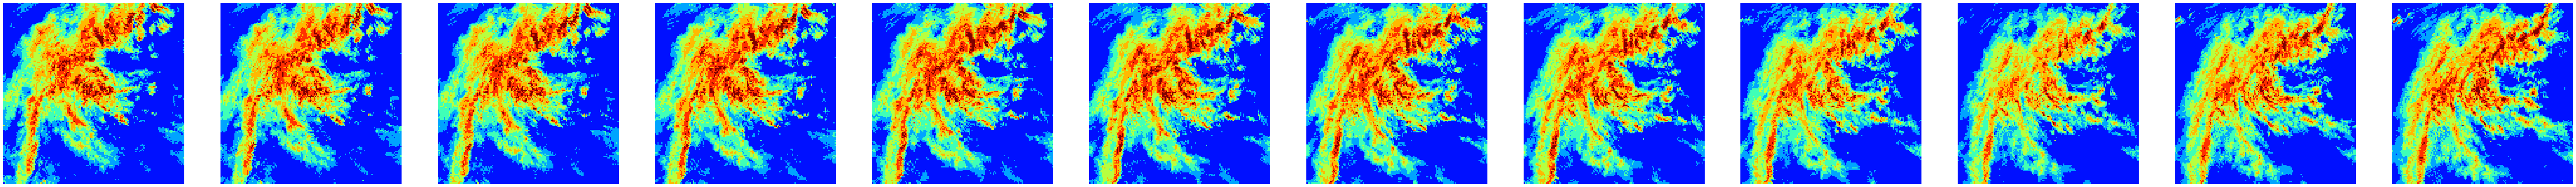

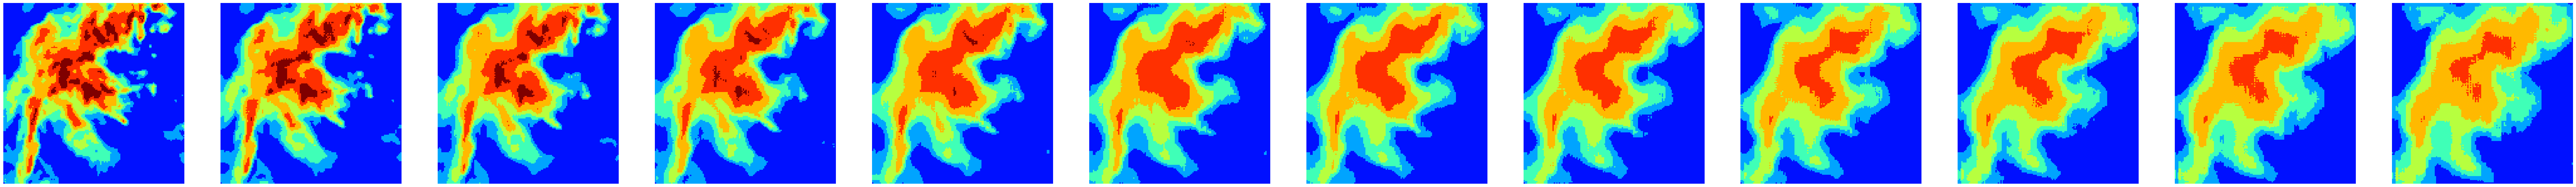

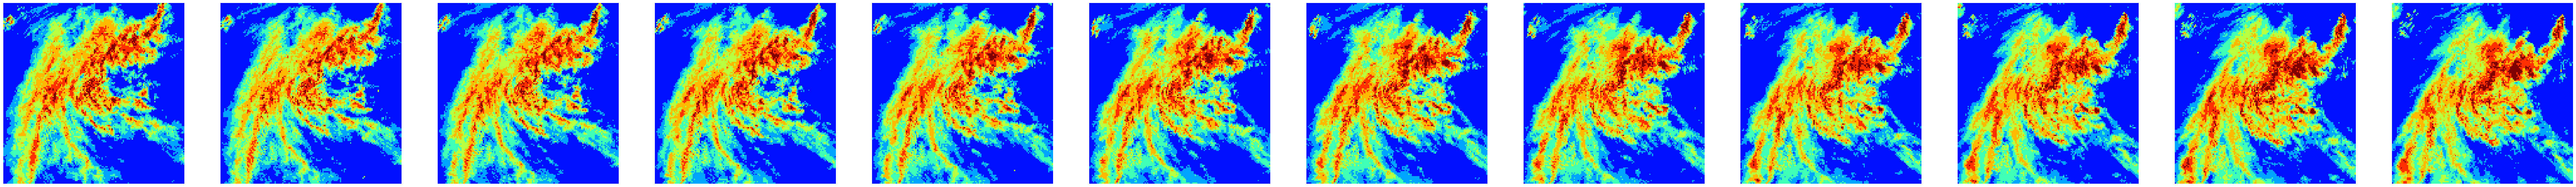

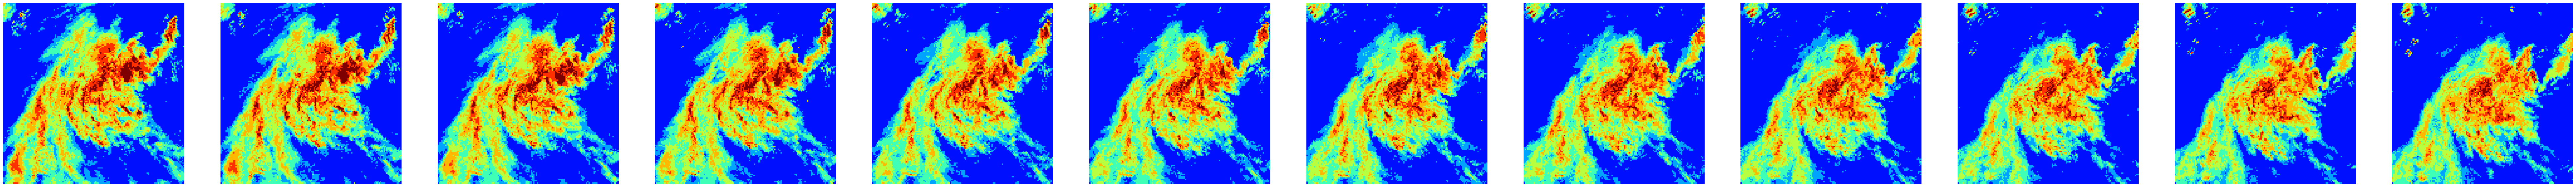

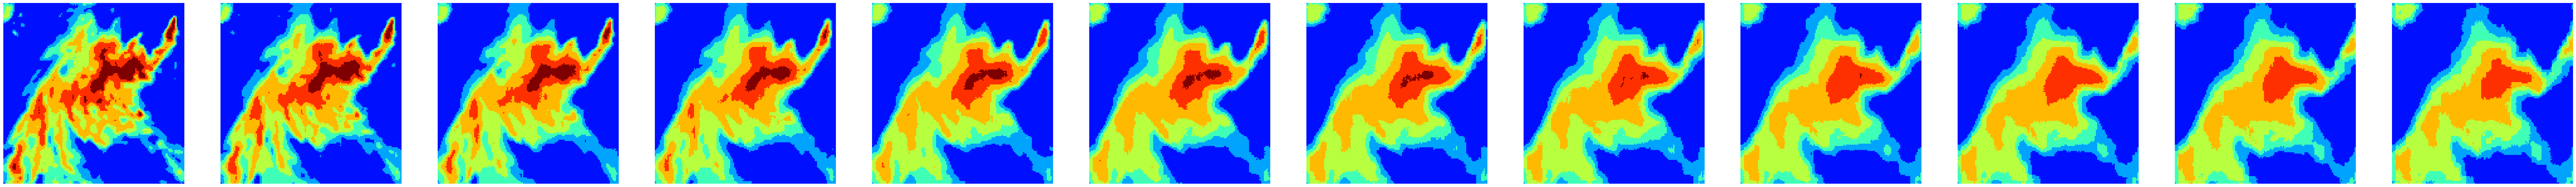

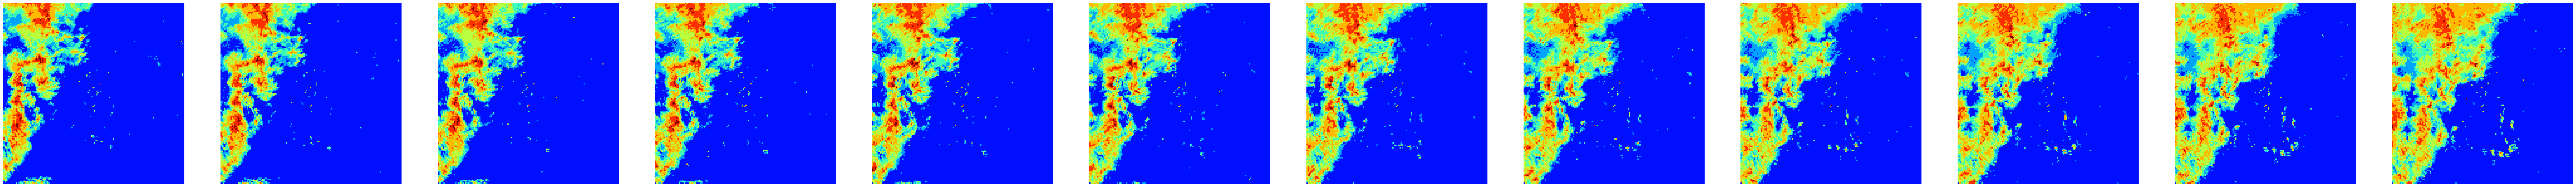

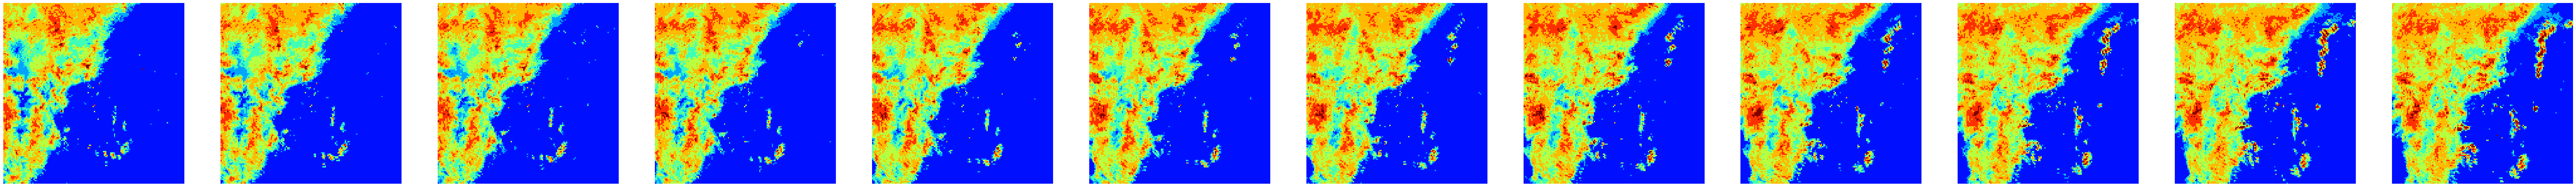

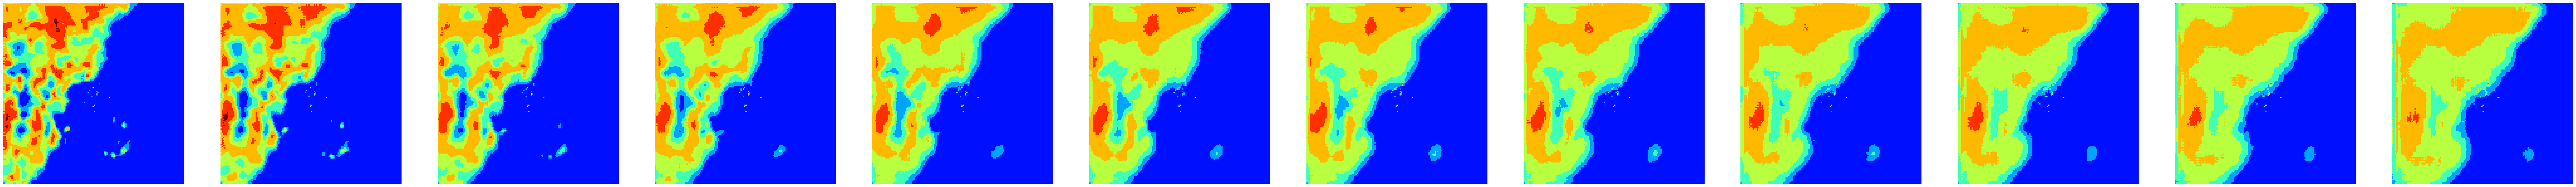

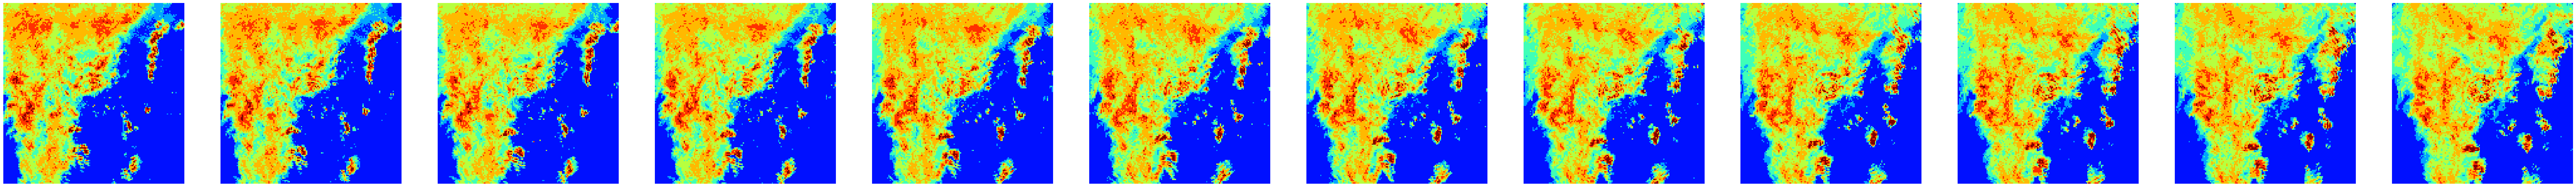

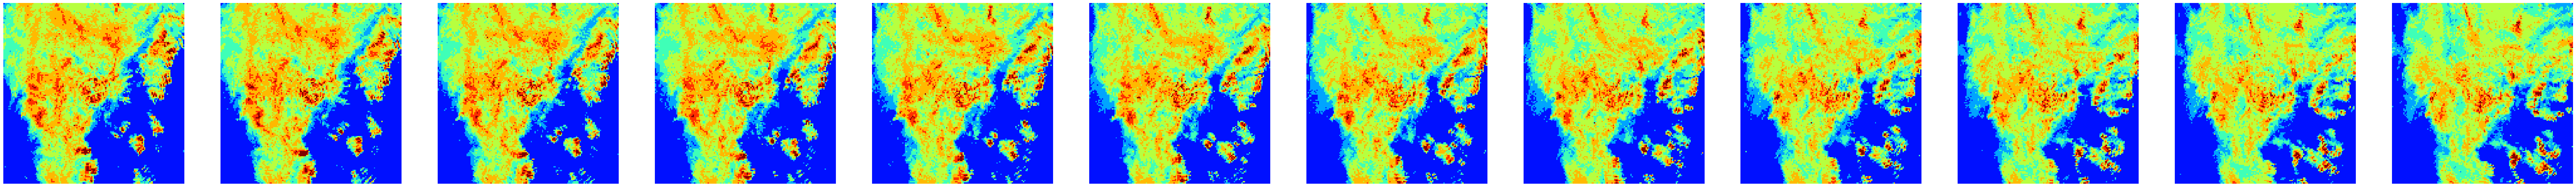

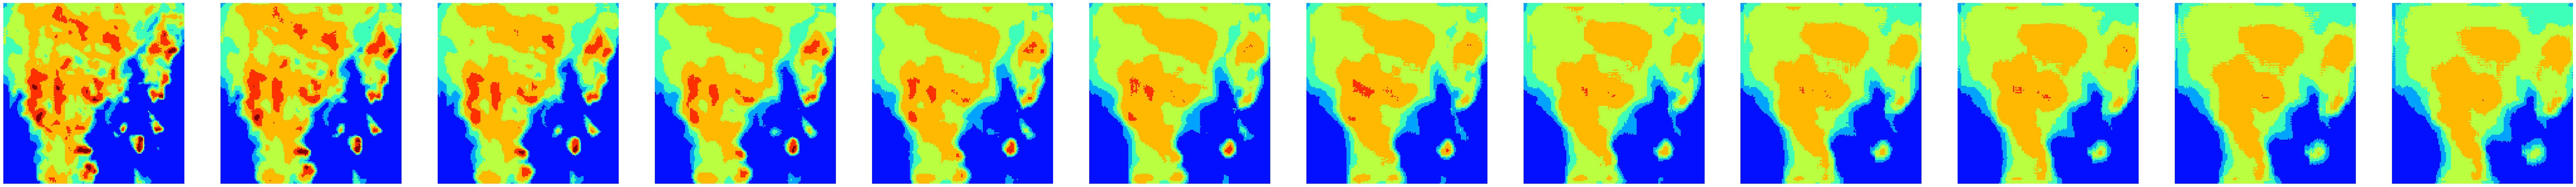

In [50]:
# Classify images into 7 groups of reflectivities
def classify_image(image_tensor):
    # Define the ranges for classification
    ranges = [10., 15., 20., 25., 30., 35.]

    # Initialize an empty tensor to store the classification results
    classified_tensor = torch.zeros_like(image_tensor, dtype=torch.long)

    # Iterate over the ranges and assign class labels based on the conditions
    for i, upper_bound in enumerate(ranges):
        if i == 0:
            mask = (image_tensor >= 0.0) & (image_tensor <= upper_bound)
        else:
            mask = (image_tensor > ranges[i-1]) & (image_tensor <= upper_bound) 
            
        classified_tensor[mask] = i + 1
        
        if i == len(ranges) - 1:
            mask = image_tensor > ranges[-1]
            classified_tensor[mask] = i + 2
            
    return classified_tensor

# Save images for model comparison 
indices= 252,304,388,433,434,435,436,437     # Images chosen for model comparison


if not os.path.exists('work_dirs/custom_exp/models'):
   os.makedirs('work_dirs/custom_exp/models')

for index in indices:
    fig, axs = plt.subplots(1, 12, figsize=(100,100))
    input_data = torch.Tensor(inputs[index][None,:])
    trues_data = torch.Tensor(trues[index][None,:])
    preds_data = torch.Tensor(preds[index][None,:])
    preds_data[preds_data < 0] = 0
    vmax = torch.max(torch.stack([input_data, trues_data, preds_data]))
    
    # Save input images
    for i in range(12):
        classified_input = classify_image(input_data[0][i][0]*70)
        axs[i].imshow(classified_input,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')

    # plt.savefig(f"work_dirs/custom_exp/models/img{index}_inputs.jpg",bbox_inches='tight')

    # Save true images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))

    for i in range(12):
        classified_true = classify_image(trues_data[0][i][0]*70)
        axs[i].imshow(classified_true,cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    # plt.show()

    # Save predicted images
    fig, axs = plt.subplots(1, 12, figsize=(100,100))

    for i in range(12):
        classified_pred = classify_image(preds_data[0][i][0]*70)
        axs[i].imshow(classified_pred.float(),cmap='jet',vmin=0,vmax=7)
        axs[i].axis('off')
    plt.savefig(f"work_dirs/custom_exp/models/img{index}_{exp.args.method}_weight_{exp.args.epoch}epochs_{exp.args.model_num}_preds.jpg",bbox_inches='tight')

In [17]:
# Save the metrics based on confuson matrix for the model

def calculate_metrics(trues_, preds_, thresh):

    bins = np.array([thresh])

    preds_thresh = np.digitize(preds_, bins)
    trues_thresh = np.digitize(trues_, bins)

    confusion_matrix = metrics.confusion_matrix(
        y_true=trues_thresh.ravel(), y_pred=preds_thresh.ravel())

    # Calculate the confusion matrix
    TN, FP, FN, TP = confusion_matrix[0, 0], confusion_matrix[0, 1], confusion_matrix[1, 0], confusion_matrix[1, 1]

    pod = TP / (TP + FN)  # Probability of detection
    far = FP / (FP + TP)  # False alarm rate
    csi = TP / (TP + FN + FP)  # Critical success index
    hss = 2*((TP * TN) - (FN * FP)) / (((TP + FN) * (FN + TN)) + ((TP + FP) * (FP + TN)))  # Heidke skill score

    return [[f"csi_{thresh}", csi], [f"hss_{thresh}", hss], [f"pod_{thresh}", pod], [f"far_{thresh}", far]]

# Save the metrics based on confusion matrix for the model

# The thresholds are the reflectivity values in dBZ for which we do the confusion matrix classification
threshs = np.array([10., 20., 30.])
metrics_ = []
# Convert the reflectivity values to dBZ
trues_ = trues * 70
preds_ = preds * 70

for thresh in threshs:
    metrics_.extend(calculate_metrics(trues_, preds_, thresh))
    
# Calculate MSE and MAE for the model
mse = F.mse_loss(torch.Tensor(trues_), torch.Tensor(preds_))
mae = F.l1_loss(torch.Tensor(trues_), torch.Tensor(preds_))

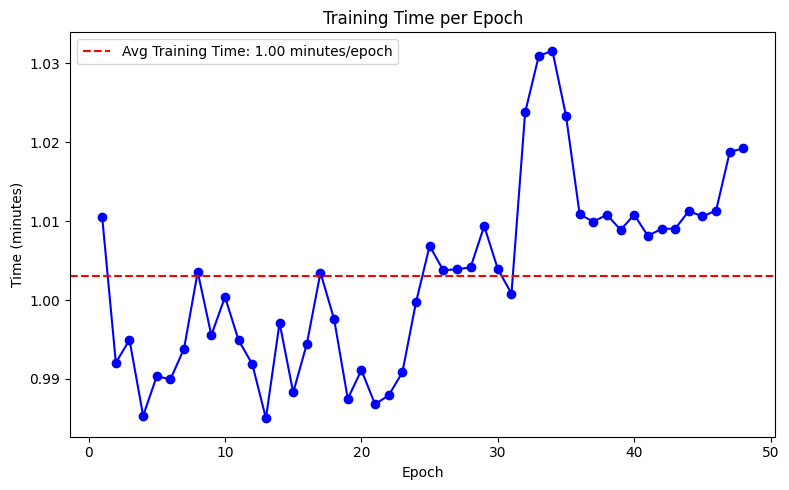

In [18]:
# Parse log file
def parse_log_line(line):
    match = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - Epoch', line)
    if match:
        timestamp_str = match.group(1)
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S,%f')
        return timestamp
    else:
        return None

# Plot average training time per epoch
def plot_avg_training_time(log_file):
    timestamps = []

    with open(log_file, 'r') as file:
        for line in file:
            result = parse_log_line(line)
            epoch = 0
            if result:
                epoch+=1
                timestamp = result
                timestamps.append((timestamp, epoch))

    # Calculate time differences
    time_diffs = [(timestamps[i][0] - timestamps[i - 1][0]).total_seconds() for i in range(1, len(timestamps))]

    # Calculate average training time per epoch in minutes
    try:
        avg_training_time = (sum(time_diffs) / len(time_diffs)) / 60
    except ZeroDivisionError:
        avg_training_time = 0

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(time_diffs) + 1), [time_diff / 60 for time_diff in time_diffs], marker='o', linestyle='-', color='b')
    plt.axhline(avg_training_time, color='r', linestyle='--', label=f'Avg Training Time: {avg_training_time:.2f} minutes/epoch')
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (minutes)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_training_time
# Example usage
m_epoch = plot_avg_training_time(log_file_path)

In [19]:
# Write the metrics in a text file
with open(f"work_dirs/custom_exp/models/{exp.args.method}_{exp.args.loss}_{exp.args.epoch}epochs_{exp.args.model_num}_metrics.txt","w") as f:
    f.write(f"MSE : {mse}, MAE : {mae} \n\n Nb params : {nb_params}, FLOPs : {flops}, Training time : {m_epoch} m/epoch,  \n\n Now-casting metrics : \n\n")
    for i,line in enumerate(metrics_):
        f.write(str(line)+"\n\n")